In [12]:
!pip install tensorflow
!pip install datasets
!pip install transformers

In [13]:
!pip install tensorflow-addons

In [38]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout

print(tf.__version__)

2.15.0


In [47]:
import numpy as np
import tensorflow_datasets as tfds

In [48]:
def preprocess(image, label):
    image = tf.image.resize(image, [96, 96])
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    return image, label


In [49]:
def augment(image, label):
    image = tf.image.resize(image, [96, 96])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1) # Adjust brightness by up to 10%
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1) # Adjust contrast between 90% and 110%
    image = tf.cast(image, tf.float32) / 255.0
    return image, label


(ds_train, ds_validation), ds_info = tfds.load(
    'malaria',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True,
)

train_ds = ds_train.map(augment).batch(32).prefetch(tf.data.AUTOTUNE)

val_ds = ds_validation.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

In [50]:
img_width = 96
img_height= 96

**Building the CNN Model**

In [51]:
model = Sequential()

model.add(Conv2D(16, (3,3), input_shape =(img_width, img_height,3),activation= 'relu'))
model.add(MaxPool2D(2,2))

model.add(Conv2D(32, (3,3),activation= 'relu'))
model.add(MaxPool2D(2,2))

model.add(Conv2D(64, (3,3),activation= 'relu'))
model.add(MaxPool2D(2,2))

model.add(Flatten())
model.add(Dense(64,activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))

In [52]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 94, 94, 16)        448       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 47, 47, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 22, 22, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 20, 20, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 10, 10, 64)       

In [53]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [55]:
history = model.fit(train_ds,
                    epochs= 10,
                    validation_data = val_ds,)

Epoch 1/10
689/689 [==============================] - 171s 248ms/step - loss: 0.1315 - accuracy: 0.9580 - val_loss: 0.1354 - val_accuracy: 0.9570
Epoch 2/10
689/689 [==============================] - 164s 238ms/step - loss: 0.1267 - accuracy: 0.9594 - val_loss: 0.1335 - val_accuracy: 0.9563
Epoch 3/10
689/689 [==============================] - 165s 239ms/step - loss: 0.1263 - accuracy: 0.9594 - val_loss: 0.1295 - val_accuracy: 0.9579
Epoch 4/10
689/689 [==============================] - 159s 231ms/step - loss: 0.1223 - accuracy: 0.9597 - val_loss: 0.1296 - val_accuracy: 0.9574
Epoch 5/10
689/689 [==============================] - 161s 233ms/step - loss: 0.1191 - accuracy: 0.9600 - val_loss: 0.1295 - val_accuracy: 0.9572
Epoch 6/10
689/689 [==============================] - 159s 230ms/step - loss: 0.1174 - accuracy: 0.9621 - val_loss: 0.1279 - val_accuracy: 0.9592
Epoch 7/10
689/689 [==============================] - 164s 237ms/step - loss: 0.1163 - accuracy: 0.9609 - val_loss: 0.1282 -

In [56]:
history.history

{'loss': [0.13145965337753296,
  0.12669570744037628,
  0.12630027532577515,
  0.12226752191781998,
  0.1191382184624672,
  0.11739974468946457,
  0.1162818893790245,
  0.11429848521947861,
  0.11293721944093704,
  0.10973918437957764],
 'accuracy': [0.9579969048500061,
  0.9594483971595764,
  0.9594483971595764,
  0.9596752524375916,
  0.9600381255149841,
  0.9621246457099915,
  0.9608545899391174,
  0.9616710543632507,
  0.9620792865753174,
  0.9614896178245544],
 'val_loss': [0.1354442983865738,
  0.1335231512784958,
  0.12947878241539001,
  0.12958696484565735,
  0.12952037155628204,
  0.12787474691867828,
  0.12820465862751007,
  0.12985442578792572,
  0.13306204974651337,
  0.1306166797876358],
 'val_accuracy': [0.9570028781890869,
  0.9562771916389465,
  0.9579100012779236,
  0.9573657512664795,
  0.9571843147277832,
  0.9591799974441528,
  0.956095814704895,
  0.9571843147277832,
  0.9570028781890869,
  0.9588171243667603]}

In [57]:
def plot_learningCurve(history, epoch):
  epoch_range= range(1, epoch+1)
  #plot training and validation accuracy values
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  #plot training and validation accuracy values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

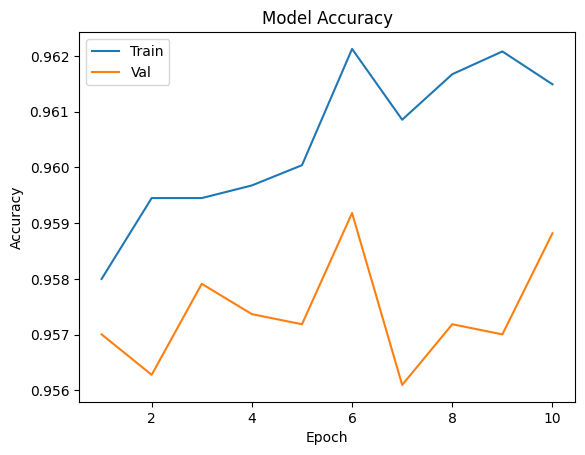

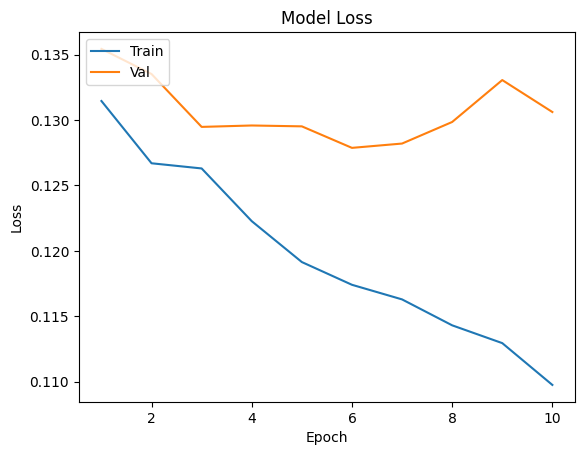

In [58]:
plot_learningCurve(history, 10)